In [ ]:
#pipenv install np pandas maxentropy sklearn plotly

In [1]:
import pandas as pd
import numpy as np
from maxentropy import FeatureTransformer, MinDivergenceModel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from scipy.stats.contingency import expected_freq
from scipy.special import xlogy
import plotly.express as px

## Principle of minimum discrimination information
> Given an intial model $\textbf{p}_0$ of a system and a set of constraints derived from empirical evidence, update to the model $\textbf{p}$ which minimizes the relative entropy $D(\textbf{p} || \textbf{p}_0)$

Often the initial model is just the uniform distribution, in which case the right intuition for this is "choose the flattest possible model which meets your constraints".
(Relative entropy is a sort of distance measure between probability distributions, so if $\textbf{p}_0$ is uniform then it provides a measure of "flatness".)

This is a standard tool for choosing priors before fitting a model to data.

### Example: loaded dice
After rolling a six sided die (with faces 1, 2, 3, 4, 5, 6) many times you observe that the average of all of the rolls is 4.5.
What statistical model should you use to predict the next roll of the die?

We'll use the package `maxentropy`, which implements algorithms for maximizing entropy / minimizing relative entropy within the sklearn API.
This implementation requires:

- A sample space: in this case, just the faces 1, 2, 3, 4, 5, 6
- A log prior: $[\log(\frac{1}{6}), \ldots, \log(\frac{1}{6})]$ for the uniform prior
- A set of features $f_i$: arbitrary functions defined on the sample space
- A set of constraints: expressed as $\mathbb{E}(f_i(X)) = C$ where $C$ is constant

In [2]:
# Sample space
sample_space = np.linspace(1, 6, 6, dtype=int)

In [3]:
sample_space

array([1, 2, 3, 4, 5, 6])

In [25]:
# Log prior
# prior = [1/6] * 6
prior = [0, 0, .25, .75, 0, 0]
log_prior = np.log(prior)

@np.vectorize
def prior_log_pdf(x):
    return log_prior[x-1]  # zero-based indexing offset

<ipython-input-25-ef16e9a9b28a>:4: RuntimeWarning:

divide by zero encountered in log



In [26]:
log_prior

array([       -inf,        -inf, -1.38629436, -0.28768207,        -inf,
              -inf])

Our constraint is just $\mathbb{E}(X) = 4.5$, so we only need one feature:

In [27]:
# Features
def identity(x):
    return x

features = [identity]

There is only one feature, so the constraint is just a single value:

In [28]:
# Constraint
C = [4.5]
constraint = np.atleast_2d(C)

Now let's compute the minimum (relative) entropy distribution:

In [29]:
model = MinDivergenceModel(features, sample_space, prior_log_pdf=prior_log_pdf)
model.fit(constraint)
model.probdist()

DivergenceError: "dual is below the threshold 'mindual' and may be diverging to -inf.  Fix the constraints or lower the threshold!"

In [ ]:
df = pd.DataFrame(model.probdist(), index=[1,2,3,4,5,6], columns=['probability'])

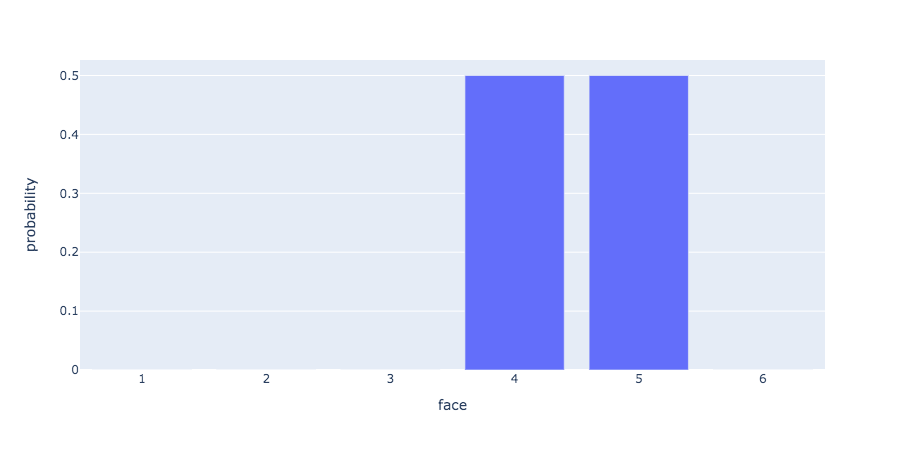

In [30]:
px.bar(model.probdist(), x=df.index, y=df['probability'], labels={'x': 'face', 'y': 'probability'})

### Exercises
1. Repeat the calculation above, using a non-uniform prior of your choice.  For instance, you could set the probability of the face 6 to 0, or make the face 1 overwhelmingly more likely than the others.

2. Repeat the calculation above using the following constraints: the average value of the face is 4.5, and the face 2 occurs 20% of the time.  (Hint: to represent the second constraint, use the boolean feature $f(x) = lambda x: x == 2$.)

3. Find the best statistical model of a pair of dice, where the average value of the sum is 9.